<a href="https://colab.research.google.com/github/akshayiitr04/satellite-property-valuation/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("/content/drive/MyDrive/satellite_project")
print(os.getcwd())


/content/drive/MyDrive/satellite_project


In [ ]:
os.listdir()


['data',
 'images',
 'data_fetcher.py',
 '__pycache__',
 'best_model.pth',
 'multimodal_architecture',
 'multimodal_architecture.jpeg',
 'gradcam_outputs',
 'High_Price_Properties_-_Explainability.jpeg',
 'Mid_Price_Properties_-_Explainability.jpeg',
 'Low_Price_Properties_-_Explainability.jpeg',
 'model_training.ipynb',
 'preprocessing.ipynb',
 '22119005_final.csv']

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install mercantile pillow requests

In [ ]:
!ls /content/drive/MyDrive/satellite_project

best_model.pth	 images			       preprocessing.ipynb
data		 model_training.ipynb	       price_predictions.csv
data_fetcher.py  multimodal_architecture       __pycache__
gradcam_outputs  multimodal_architecture.jpeg


#DOWNLOADING MODULE FROM DATA_FETCHER

In [ ]:
from data_fetcher import save_satellite_image

# save_satellite_image(
#     lat=48.1593,
#     lon=-122.5192,
#     image_id="house_003"
# )

hello
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#DOWNLOADING IMAGE FOR TRAIN DATA

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/satellite_project/data/processed/train_processed.csv")
train.shape


(16206, 17)

In [ ]:
train.head()

,id,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te
0,9117000170,12.501142,4,2.25,2.0,0,0,3,7,7.501634,0.00000,47.4362,-122.187,9.131405,54,0,12.628271
1,6700390210,12.409018,3,2.50,2.0,0,0,4,7,7.378384,0.00000,47.4034,-122.187,8.190354,22,0,12.621663
2,7212660540,12.206078,4,2.50,2.0,0,0,3,8,7.450661,0.00000,47.2704,-122.313,8.916774,21,0,12.579669
3,8562780200,12.772806,2,2.25,2.0,0,0,3,7,7.048386,4.51086,47.5321,-122.073,6.621406,6,0,13.335357
4,7760400350,12.354497,3,2.00,1.0,0,0,3,7,7.155396,0.00000,47.3715,-122.074,8.996157,20,0,12.657948


In [ ]:
for _, row in train.iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]
    path = save_satellite_image(int(image_id),lati,longi )

# def save_satellite_image(image_id, lat, lon,
#                          base_dir="/content/drive/MyDrive/satellite_project/images/raw",
#                          zoom=19, tiles_across=3):


#DOWNLOADING IMAGE FOR TEST DATA

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/satellite_project/data/processed/test_processed.csv")
test.shape

(5404, 16)

In [ ]:
test.head()

,id,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te
0,2591820310,4,2.25,2.0,0,0,4,8,7.635787,0.000000,47.4388,-122.162,8.949105,28,0,12.753140
1,7974200820,5,3.00,1.0,0,0,5,8,7.512618,6.976348,47.6784,-122.285,8.745762,37,0,13.336040
2,7701450110,4,2.50,2.0,0,2,3,11,8.235095,0.000000,47.5646,-122.129,9.178437,17,0,13.684213
3,9522300010,3,3.50,2.0,0,2,3,12,8.425297,0.000000,47.6995,-122.228,9.562897,25,0,13.153954
4,9510861140,3,2.50,2.0,0,0,3,9,7.844241,0.000000,47.6647,-122.083,8.306719,10,0,13.385821


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5404 non-null   int64  
 1   bedrooms       5404 non-null   int64  
 2   bathrooms      5404 non-null   float64
 3   floors         5404 non-null   float64
 4   waterfront     5404 non-null   int64  
 5   view           5404 non-null   int64  
 6   condition      5404 non-null   int64  
 7   grade          5404 non-null   int64  
 8   sqft_above     5404 non-null   float64
 9   sqft_basement  5404 non-null   float64
 10  lat            5404 non-null   float64
 11  long           5404 non-null   float64
 12  sqft_lot15     5404 non-null   float64
 13  house_age      5404 non-null   int64  
 14  is_renovated   5404 non-null   int64  
 15  zipcode_te     5404 non-null   float64
dtypes: float64(8), int64(8)
memory usage: 675.6 KB


In [ ]:
for _, row in train.iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]
    path = save_satellite_image(int(image_id), lati, longi,  base_dir="/content/drive/MyDrive/satellite_project/images/processed")

In [ ]:

for i, row in test.head(5).iterrows():
    lati = row["lat"]
    longi = row["long"]
    image_id = row["id"]

    path = save_satellite_image(int(image_id), lati, longi,  base_dir="/content/drive/MyDrive/satellite_project/images/processed")

Saved image 2591820310
Saved image 7974200820
Saved image 7701450110
Saved image 9522300010
Saved image 9510861140


#Training loop for the multimodal model.

In [ ]:
!pip install torch torchvision pandas scikit-learn tqdm

In [ ]:
!cp -r /content/drive/MyDrive/satellite_project/images /content/images


In [ ]:
!ls /content/images | head


processed
raw


In [ ]:
!ls /content/images/raw | head
!ls /content/images/processed | head


1000102.jpg
1001200050.jpg
1003000175.jpg
100300280.jpg
100300530.jpg
1003400155.jpg
1003400245.jpg
1003400250.jpg
1003600056.jpg
1003600080.jpg
1000102.jpg
100100050.jpg
1001200035.jpg
100300500.jpg
1005000036.jpg
1005000220.jpg
1005000240.jpg
100600320.jpg
100600860.jpg
1020069017.jpg


In [ ]:
# Directoriezzs
DATA_DIR  = "/content/drive/MyDrive/satellite_project/data/processed"

# Data
train_df = pd.read_csv(f"{DATA_DIR}/train_processed.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test_processed.csv")

TARGET_COL = "price"
ID_COL = "id"
IMAGE_COL = "image_path"

TRAIN_IMAGE_DIR = "/content/images/raw"

train_df["image_path"] = train_df["id"].astype(str).apply(
    lambda x: f"{TRAIN_IMAGE_DIR}/{x}.jpg"
)


TEST_IMAGE_DIR = "/content/images/processed"

test_df["image_path"] = test_df["id"].astype(str).apply(
    lambda x: f"{TEST_IMAGE_DIR}/{x}.jpg"
)


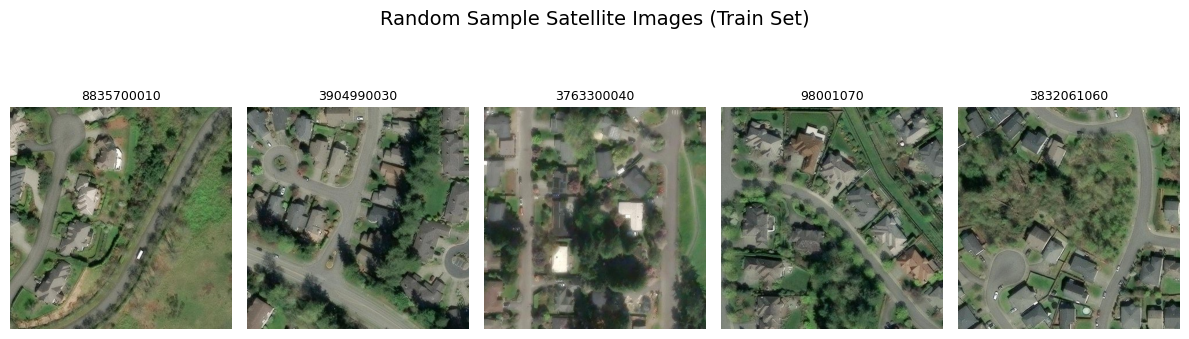

In [ ]:
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/satellite_project/images/raw"

# pick 5 random ids from train_df
sample_ids = train_df['id'].sample(5, random_state=None)

plt.figure(figsize=(12,4))

for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(TRAIN_IMAGE_DIR, f"{img_id}.jpg")
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(str(img_id), fontsize=9)
    plt.axis("off")

plt.suptitle("Random Sample Satellite Images (Train Set)", fontsize=14)
plt.tight_layout()
plt.show()


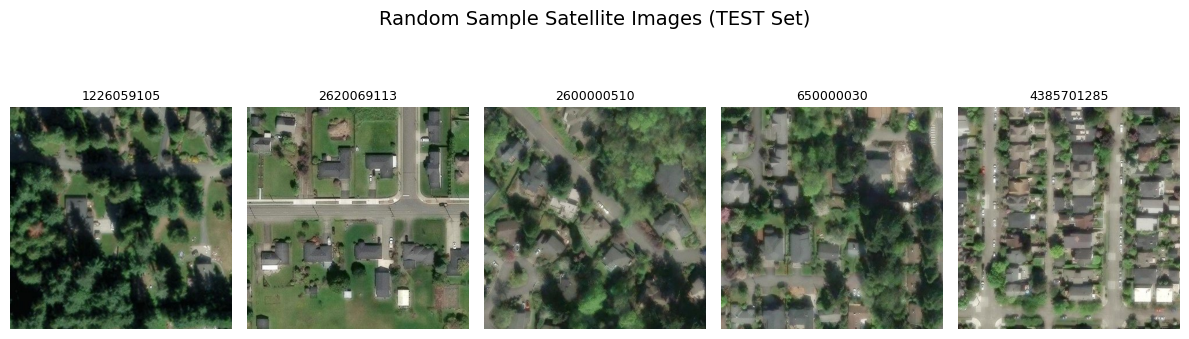

In [ ]:
TEST_IMAGE_DIR = "/content/drive/MyDrive/satellite_project/images/processed"

# pick 5 random ids from test_df
sample_ids = test_df['id'].sample(5, random_state=None)

plt.figure(figsize=(12,4))

for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(TEST_IMAGE_DIR, f"{img_id}.jpg")
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(str(img_id), fontsize=9)
    plt.axis("off")

plt.suptitle("Random Sample Satellite Images (TEST Set)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

print(train_df["image_path"].iloc[0])
print(os.path.exists(train_df["image_path"].iloc[0]))

print(test_df["image_path"].iloc[0])
print(os.path.exists(test_df["image_path"].iloc[0]))


/content/images/raw/9117000170.jpg
True
/content/images/processed/2591820310.jpg
True


In [ ]:
X = train_df.copy()

X_train, X_val = train_test_split(
    X, test_size=0.2, random_state=42
)

y_train = X_train[TARGET_COL]
y_val   = X_val[TARGET_COL]


In [ ]:
TABULAR_DROP_COLS = [IMAGE_COL, ID_COL, TARGET_COL]

scaler = StandardScaler()

X_train_tab = scaler.fit_transform(
    X_train.drop(columns=TABULAR_DROP_COLS)
).astype("float32")

X_val_tab = scaler.transform(
    X_val.drop(columns=TABULAR_DROP_COLS)
).astype("float32")


In [ ]:
class HousePriceDataset(Dataset):
    def __init__(self, df, tabular_data, transform=None):
        self.df = df.reset_index(drop=True)
        self.tabular_data = tabular_data
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, IMAGE_COL]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        tab = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        y   = torch.tensor(self.df.loc[idx, TARGET_COL], dtype=torch.float32)

        return image, tab, y


In [ ]:
image_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_ds = HousePriceDataset(X_train, X_train_tab, image_transforms)
val_ds   = HousePriceDataset(X_val,   X_val_tab,   image_transforms)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()

        self.cnn = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn.fc = nn.Identity()

        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(x).squeeze(1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CombinedModel(X_train_tab.shape[1]).to(device)

for name, param in model.cnn.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


criterion = nn.MSELoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)


EPOCHS = 50
patience = 5
best_val_loss = float("inf")
counter = 0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []

    for imgs, tabs, targets in tqdm(train_loader):
        imgs = imgs.to(device)
        tabs = tabs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, tabs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(targets.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_r2 = r2_score(train_targets, train_preds)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for imgs, tabs, targets in val_loader:
            imgs = imgs.to(device)
            tabs = tabs.to(device)
            targets = targets.to(device)

            outputs = model(imgs, tabs)
            val_loss += criterion(outputs, targets).item()

            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_r2 = r2_score(val_targets, val_preds)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train MSE: {train_loss:.4f} | Train R²: {train_r2:.4f} | "
        f"Val MSE: {val_loss:.4f} | Val R²: {val_r2:.4f}"
    )

    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping triggered")
            break


100%|██████████| 406/406 [00:55<00:00,  7.28it/s]


Epoch 1/50 | Train MSE: 13.5466 | Train R²: -47.9321 | Val MSE: 0.1784 | Val R²: 0.3167


100%|██████████| 406/406 [00:53<00:00,  7.52it/s]


Epoch 2/50 | Train MSE: 0.1015 | Train R²: 0.6359 | Val MSE: 0.1068 | Val R²: 0.5904


100%|██████████| 406/406 [01:02<00:00,  6.51it/s]


Epoch 3/50 | Train MSE: 0.0599 | Train R²: 0.7843 | Val MSE: 0.1009 | Val R²: 0.6131


100%|██████████| 406/406 [00:55<00:00,  7.36it/s]


Epoch 4/50 | Train MSE: 0.0418 | Train R²: 0.8504 | Val MSE: 0.0976 | Val R²: 0.6244


100%|██████████| 406/406 [00:55<00:00,  7.37it/s]


Epoch 5/50 | Train MSE: 0.0319 | Train R²: 0.8854 | Val MSE: 0.0875 | Val R²: 0.6638


100%|██████████| 406/406 [00:54<00:00,  7.39it/s]


Epoch 6/50 | Train MSE: 0.0314 | Train R²: 0.8869 | Val MSE: 0.0699 | Val R²: 0.7319


100%|██████████| 406/406 [00:54<00:00,  7.45it/s]


Epoch 7/50 | Train MSE: 0.0258 | Train R²: 0.9076 | Val MSE: 0.0673 | Val R²: 0.7418


100%|██████████| 406/406 [00:55<00:00,  7.38it/s]


Epoch 8/50 | Train MSE: 0.0243 | Train R²: 0.9134 | Val MSE: 0.0730 | Val R²: 0.7193


100%|██████████| 406/406 [00:52<00:00,  7.66it/s]


Epoch 9/50 | Train MSE: 0.0234 | Train R²: 0.9157 | Val MSE: 0.0573 | Val R²: 0.7797


100%|██████████| 406/406 [00:53<00:00,  7.54it/s]


Epoch 10/50 | Train MSE: 0.0203 | Train R²: 0.9269 | Val MSE: 0.0551 | Val R²: 0.7882


100%|██████████| 406/406 [00:54<00:00,  7.45it/s]


Epoch 11/50 | Train MSE: 0.0198 | Train R²: 0.9300 | Val MSE: 0.0525 | Val R²: 0.7992


100%|██████████| 406/406 [00:54<00:00,  7.46it/s]


Epoch 12/50 | Train MSE: 0.0175 | Train R²: 0.9372 | Val MSE: 0.0542 | Val R²: 0.7918


100%|██████████| 406/406 [00:54<00:00,  7.44it/s]


Epoch 13/50 | Train MSE: 0.0177 | Train R²: 0.9363 | Val MSE: 0.0493 | Val R²: 0.8106


100%|██████████| 406/406 [00:53<00:00,  7.66it/s]


Epoch 14/50 | Train MSE: 0.0180 | Train R²: 0.9355 | Val MSE: 0.0547 | Val R²: 0.7901


100%|██████████| 406/406 [00:53<00:00,  7.53it/s]


Epoch 15/50 | Train MSE: 0.0160 | Train R²: 0.9425 | Val MSE: 0.0485 | Val R²: 0.8137


100%|██████████| 406/406 [00:54<00:00,  7.44it/s]


Epoch 16/50 | Train MSE: 0.0147 | Train R²: 0.9468 | Val MSE: 0.0570 | Val R²: 0.7810


100%|██████████| 406/406 [00:53<00:00,  7.55it/s]


Epoch 17/50 | Train MSE: 0.0155 | Train R²: 0.9447 | Val MSE: 0.0454 | Val R²: 0.8257


100%|██████████| 406/406 [00:55<00:00,  7.33it/s]


Epoch 18/50 | Train MSE: 0.0157 | Train R²: 0.9433 | Val MSE: 0.0447 | Val R²: 0.8285


100%|██████████| 406/406 [00:54<00:00,  7.49it/s]


Epoch 19/50 | Train MSE: 0.0139 | Train R²: 0.9499 | Val MSE: 0.0488 | Val R²: 0.8129


100%|██████████| 406/406 [00:53<00:00,  7.58it/s]


Epoch 20/50 | Train MSE: 0.0122 | Train R²: 0.9563 | Val MSE: 0.0423 | Val R²: 0.8376


100%|██████████| 406/406 [00:54<00:00,  7.39it/s]


Epoch 21/50 | Train MSE: 0.0134 | Train R²: 0.9519 | Val MSE: 0.0418 | Val R²: 0.8392


100%|██████████| 406/406 [00:53<00:00,  7.54it/s]


Epoch 22/50 | Train MSE: 0.0125 | Train R²: 0.9548 | Val MSE: 0.0456 | Val R²: 0.8248


100%|██████████| 406/406 [00:52<00:00,  7.69it/s]


Epoch 23/50 | Train MSE: 0.0126 | Train R²: 0.9544 | Val MSE: 0.0491 | Val R²: 0.8116


100%|██████████| 406/406 [00:52<00:00,  7.69it/s]


Epoch 24/50 | Train MSE: 0.0124 | Train R²: 0.9557 | Val MSE: 0.0427 | Val R²: 0.8361


100%|██████████| 406/406 [00:52<00:00,  7.74it/s]


Epoch 25/50 | Train MSE: 0.0139 | Train R²: 0.9499 | Val MSE: 0.0398 | Val R²: 0.8472


100%|██████████| 406/406 [00:54<00:00,  7.49it/s]


Epoch 26/50 | Train MSE: 0.0118 | Train R²: 0.9578 | Val MSE: 0.0468 | Val R²: 0.8199


100%|██████████| 406/406 [00:51<00:00,  7.83it/s]


Epoch 27/50 | Train MSE: 0.0107 | Train R²: 0.9616 | Val MSE: 0.0389 | Val R²: 0.8506


100%|██████████| 406/406 [00:53<00:00,  7.60it/s]


Epoch 28/50 | Train MSE: 0.0104 | Train R²: 0.9625 | Val MSE: 0.0388 | Val R²: 0.8508


100%|██████████| 406/406 [00:53<00:00,  7.62it/s]


Epoch 29/50 | Train MSE: 0.0108 | Train R²: 0.9611 | Val MSE: 0.0401 | Val R²: 0.8462


100%|██████████| 406/406 [00:52<00:00,  7.74it/s]


Epoch 30/50 | Train MSE: 0.0099 | Train R²: 0.9643 | Val MSE: 0.0413 | Val R²: 0.8412


100%|██████████| 406/406 [00:53<00:00,  7.59it/s]


Epoch 31/50 | Train MSE: 0.0102 | Train R²: 0.9632 | Val MSE: 0.0399 | Val R²: 0.8467


100%|██████████| 406/406 [00:53<00:00,  7.63it/s]


Epoch 32/50 | Train MSE: 0.0105 | Train R²: 0.9622 | Val MSE: 0.0395 | Val R²: 0.8481


100%|██████████| 406/406 [00:53<00:00,  7.62it/s]


Epoch 33/50 | Train MSE: 0.0101 | Train R²: 0.9636 | Val MSE: 0.0367 | Val R²: 0.8587


100%|██████████| 406/406 [00:53<00:00,  7.61it/s]


Epoch 34/50 | Train MSE: 0.0092 | Train R²: 0.9668 | Val MSE: 0.0514 | Val R²: 0.8028


100%|██████████| 406/406 [00:53<00:00,  7.56it/s]


Epoch 35/50 | Train MSE: 0.0096 | Train R²: 0.9654 | Val MSE: 0.0405 | Val R²: 0.8445


100%|██████████| 406/406 [00:53<00:00,  7.65it/s]


Epoch 36/50 | Train MSE: 0.0096 | Train R²: 0.9653 | Val MSE: 0.0394 | Val R²: 0.8485


100%|██████████| 406/406 [00:52<00:00,  7.80it/s]


Epoch 37/50 | Train MSE: 0.0091 | Train R²: 0.9671 | Val MSE: 0.0378 | Val R²: 0.8548


100%|██████████| 406/406 [00:53<00:00,  7.57it/s]


Epoch 38/50 | Train MSE: 0.0096 | Train R²: 0.9659 | Val MSE: 0.0511 | Val R²: 0.8036
🛑 Early stopping triggered


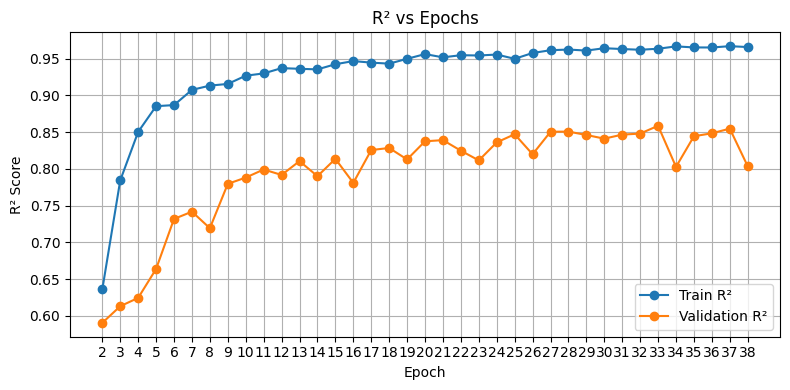

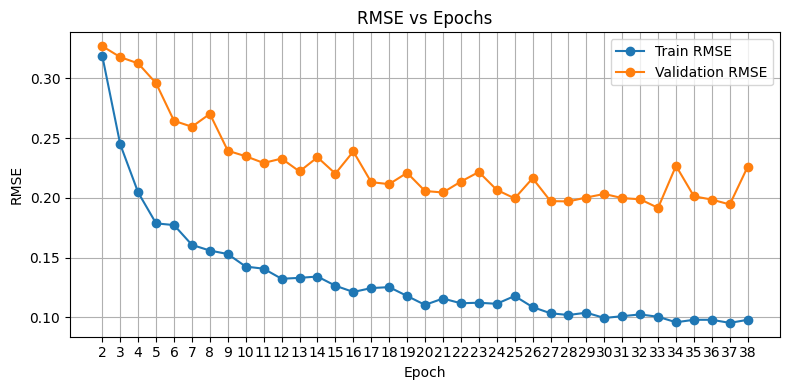

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Epoch numbers (1-based)
# -------------------------------
epochs = list(range(1, 39))  # 38 epochs actually run

# -------------------------------
# Train & Val metrics from your logs
# -------------------------------
train_r2 = [
    -47.9321, 0.6359, 0.7843, 0.8504, 0.8854, 0.8869, 0.9076, 0.9134, 0.9157,
    0.9269, 0.9300, 0.9372, 0.9363, 0.9355, 0.9425, 0.9468, 0.9447, 0.9433,
    0.9499, 0.9563, 0.9519, 0.9548, 0.9544, 0.9557, 0.9499, 0.9578, 0.9616,
    0.9625, 0.9611, 0.9643, 0.9632, 0.9622, 0.9636, 0.9668, 0.9654, 0.9653,
    0.9671, 0.9659
]

val_r2 = [
    0.3167, 0.5904, 0.6131, 0.6244, 0.6638, 0.7319, 0.7418, 0.7193, 0.7797,
    0.7882, 0.7992, 0.7918, 0.8106, 0.7901, 0.8137, 0.7810, 0.8257, 0.8285,
    0.8129, 0.8376, 0.8392, 0.8248, 0.8116, 0.8361, 0.8472, 0.8199, 0.8506,
    0.8508, 0.8462, 0.8412, 0.8467, 0.8481, 0.8587, 0.8028, 0.8445, 0.8485,
    0.8548, 0.8036
]

train_mse = [
    13.5466, 0.1015, 0.0599, 0.0418, 0.0319, 0.0314, 0.0258, 0.0243, 0.0234,
    0.0203, 0.0198, 0.0175, 0.0177, 0.0180, 0.0160, 0.0147, 0.0155, 0.0157,
    0.0139, 0.0122, 0.0134, 0.0125, 0.0126, 0.0124, 0.0139, 0.0118, 0.0107,
    0.0104, 0.0108, 0.0099, 0.0102, 0.0105, 0.0101, 0.0092, 0.0096, 0.0096,
    0.0091, 0.0096
]

val_mse = [
    0.1784, 0.1068, 0.1009, 0.0976, 0.0875, 0.0699, 0.0673, 0.0730, 0.0573,
    0.0551, 0.0525, 0.0542, 0.0493, 0.0547, 0.0485, 0.0570, 0.0454, 0.0447,
    0.0488, 0.0423, 0.0418, 0.0456, 0.0491, 0.0427, 0.0398, 0.0468, 0.0389,
    0.0388, 0.0401, 0.0413, 0.0399, 0.0395, 0.0367, 0.0514, 0.0405, 0.0394,
    0.0378, 0.0511
]

# -------------------------------
# RMSE from MSE
# -------------------------------
train_rmse = [np.sqrt(m) for m in train_mse]
val_rmse   = [np.sqrt(m) for m in val_mse]

# -------------------------------
# Plot R²
# -------------------------------
skip = 1  # ignore first unstable epoch
plt.figure(figsize=(8,4))
plt.plot(epochs[skip:], train_r2[skip:], marker='o', label="Train R²")
plt.plot(epochs[skip:], val_r2[skip:], marker='o', label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs")
plt.xticks(epochs[skip:])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Plot RMSE
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(epochs[skip:], train_rmse[skip:], marker='o', label="Train RMSE")
plt.plot(epochs[skip:], val_rmse[skip:], marker='o', label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Epochs")
plt.xticks(epochs[skip:])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Testing the model

In [ ]:
test_tab_data = test_df.drop(columns=[ID_COL, IMAGE_COL]).values.astype("float32")

# Add a dummy TARGET_COL to test_df to satisfy HousePriceDataset's __getitem__
if TARGET_COL not in test_df.columns:
    test_df[TARGET_COL] = 0.0 # Placeholder value

test_ds = HousePriceDataset(test_df, test_tab_data, image_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

# Make predictions on test data
test_preds = []
with torch.no_grad():
    for imgs, tabs, _ in test_loader:
        imgs, tabs = imgs.to(device), tabs.to(device)
        outputs = model(imgs, tabs)
        test_preds.extend(outputs.cpu().numpy())

# Add predictions to test_df
test_df["predicted_price"] = test_preds

In [ ]:
test_df.head()

,id,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_lot15,house_age,is_renovated,zipcode_te,image_path,price,predicted_price
0,2591820310,4,2.25,2.0,0,0,4,8,7.635787,0.000000,47.4388,-122.162,8.949105,28,0,12.753140,/content/images/processed/2591820310.jpg,0.0,12.994825
1,7974200820,5,3.00,1.0,0,0,5,8,7.512618,6.976348,47.6784,-122.285,8.745762,37,0,13.336040,/content/images/processed/7974200820.jpg,0.0,13.509711
2,7701450110,4,2.50,2.0,0,2,3,11,8.235095,0.000000,47.5646,-122.129,9.178437,17,0,13.684213,/content/images/processed/7701450110.jpg,0.0,13.969395
3,9522300010,3,3.50,2.0,0,2,3,12,8.425297,0.000000,47.6995,-122.228,9.562897,25,0,13.153954,/content/images/processed/9522300010.jpg,0.0,14.241956
4,9510861140,3,2.50,2.0,0,0,3,9,7.844241,0.000000,47.6647,-122.083,8.306719,10,0,13.385821,/content/images/processed/9510861140.jpg,0.0,13.342177


In [ ]:
import numpy as np
import pandas as pd

# Assuming `test_df` now has a column `predicted_price` in the log scale
test_df["predicted_price_original"] = np.exp(test_df["predicted_price"])

# Prepare final CSV with required format
submission_df = test_df[[ID_COL, "predicted_price_original"]].rename(
    columns={"predicted_price_original": "predicted_price"}
)

# Save to CSV
submission_df.to_csv("price_predictions.csv", index=False)
print("Prediction file saved: price_predictions.csv")

In [ ]:
# Define folder path
output_dir = "/content/drive/MyDrive/satellite_project"

# Make sure the folder exists
import os
os.makedirs(output_dir, exist_ok=True)

# Save CSV in that folder
submission_path = os.path.join(output_dir, "price_predictions.csv")
submission_df.to_csv(submission_path, index=False)
print(f"Prediction file saved at: {submission_path}")


✅ Prediction file saved at: /content/drive/MyDrive/satellite_project/price_predictions.csv


#GRADCAM VISUALS

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()

        self.cnn = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn.fc = nn.Identity()

        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        x = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(x).squeeze(1)

In [ ]:
# Re-instantiate the model to clear any old hooks and load trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel(X_train_tab.shape[1]).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

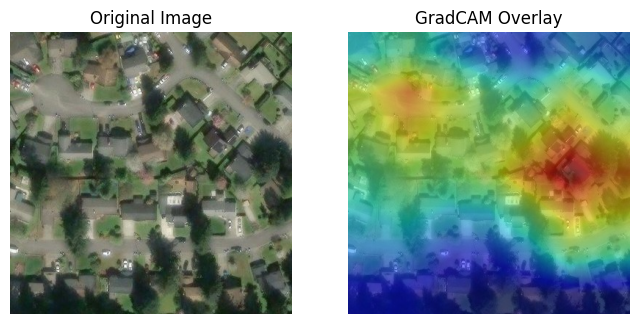

In [ ]:
import cv2
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._hook_handles = [] # To keep track of our hooks

        # Explicitly clear any existing hooks on the target layer before registering our own
        # This is a bit hacky, accessing internal PyTorch attributes, but should resolve the conflict
        if hasattr(self.target_layer, '_backward_hooks'):
            self.target_layer._backward_hooks.clear()
        if hasattr(self.target_layer, '_full_backward_hooks'):
            self.target_layer._full_backward_hooks.clear()

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            # grad_out[0] contains the gradient with respect to the output of the module
            self.gradients = grad_out[0]

        # Register forward hook and store its handle
        handle_f = self.target_layer.register_forward_hook(forward_hook)
        self._hook_handles.append(handle_f)

        # Register full backward hook and store its handle
        handle_b = self.target_layer.register_full_backward_hook(backward_hook)
        self._hook_handles.append(handle_b)

    def generate(self, image_tensor):
        self.model.zero_grad()

        # Ensure CNN parameters require gradients for GradCAM computation
        for param in self.model.cnn.parameters():
            param.requires_grad = True

        output = self.model.cnn(image_tensor)
        score = output.mean()          # regression-safe
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

    def remove_hooks(self):
        for handle in self._hook_handles:
            handle.remove()
        self._hook_handles = []

    def __del__(self):
        self.remove_hooks()


# Load a sample image and prepare it
idx = 5  # any test index
img_path = test_df.loc[idx, IMAGE_COL]

img = Image.open(img_path).convert("RGB")
img_tensor = image_transforms(img).unsqueeze(0).to(device)

# Instantiate GradCAM and generate CAM
gradcam = GradCAM(model, model.cnn.layer4)
cam = gradcam.generate(img_tensor)

plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# GradCAM overlay
plt.subplot(1, 2, 2)
plt.imshow(img)
# Resize CAM to original image dimensions for overlay
cam_resized = cv2.resize(cam, (img.width, img.height))
plt.imshow(cam_resized, cmap='jet', alpha=0.5) # Overlay with a colormap
plt.title("GradCAM Overlay")
plt.axis("off")

plt.show()

In [ ]:
pred_df = pd.read_csv(
    "/content/drive/MyDrive/satellite_project/price_predictions.csv"
)
# expected columns: id, predicted_price


In [ ]:
pred_df.head()

,id,predicted_price
0,2591820310,440129.97
1,7974200820,736534.44
2,7701450110,1166355.80
3,9522300010,1531802.50
4,9510861140,622922.50


In [ ]:
pred_df[IMAGE_COL] = pred_df["id"].astype(str).apply(
    lambda x: f"{TEST_IMAGE_DIR}/{x}.jpg"
)

In [ ]:
q25 = pred_df["predicted_price"].quantile(0.25)
q75 = pred_df["predicted_price"].quantile(0.75)

high_df = pred_df[pred_df["predicted_price"] >= q75].head(6)
mid_df  = pred_df[
    (pred_df["predicted_price"] > q25) &
    (pred_df["predicted_price"] < q75)
].head(6)
low_df  = pred_df[pred_df["predicted_price"] <= q25].head(6)


In [ ]:
import os

def plot_side_by_side_gradcam(df, title, save_dir="/content/drive/MyDrive/satellite_project/"):
    gradcam = GradCAM(model, model.cnn.layer4)

    # 🔥 NEW: create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(14, 4 * len(df)))

    for i, (_, row) in enumerate(df.iterrows()):
        img_path = row[IMAGE_COL]

        img = Image.open(img_path).convert("RGB")
        img_tensor = image_transforms(img).unsqueeze(0).to(device)

        cam = gradcam.generate(img_tensor)
        cam_resized = cv2.resize(cam, (img.width, img.height))

        # Original
        ax1 = plt.subplot(len(df), 2, 2*i + 1)
        ax1.imshow(img)
        ax1.axis("off")
        if i == 0:
            ax1.set_title("Original", fontsize=12)

        # Grad-CAM
        ax2 = plt.subplot(len(df), 2, 2*i + 2)
        ax2.imshow(img)
        ax2.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax2.axis("off")
        if i == 0:
            ax2.set_title("Grad-CAM", fontsize=12)

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 🔥 NEW: save figure
    file_name = title.replace(" ", "_").replace("–", "-") + ".jpeg"
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    print(f"✅ Saved Grad-CAM to: {save_path}")


In [ ]:
plot_side_by_side_gradcam(high_df, "High Price Properties – Explainability")
plot_side_by_side_gradcam(mid_df,  "Mid Price Properties – Explainability")
plot_side_by_side_gradcam(low_df,  "Low Price Properties – Explainability")
